<a href="https://colab.research.google.com/github/AbdulrahmanAbdulqawi/ASP.NET-Core-Identity-Authentication-Management/blob/main/OrGateWithFourLines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.nn.parameter import Parameter

In [ ]:
def gen_data(num_samples, noise=7):
  points = []
  labels = []

  for i in range(num_samples):
    x = np.random.uniform()
    y = np.random.uniform()

    nx = np.random.uniform(low=-noise/1000, high=noise/1000)
    ny = np.random.uniform(low=-noise/1000, high=noise/1000)


    if(7.7*x-2.0 < 0 or 7.7*x-3.5>0 or -0.3*x-y +0.5 > 0 or -0.3*x-y +0.8 < 0  ):
        if noise > 0:
            points.append([x+nx, y+ny, 0])
            labels.append(0)
        else:
            points.append([x, y, 0])
            labels.append(0)
    else:
        if noise > 0:
            points.append([x+nx, y+ny, 1])
            labels.append(1)
        else:
            points.append([x, y, 1])
            labels.append(1)

  return points, labels

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/RangeFactories.cpp:23.)
  


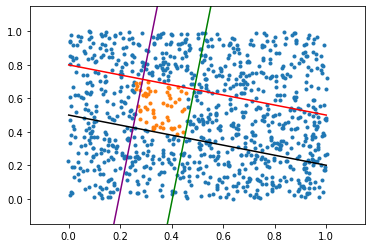

In [ ]:
points, labels = gen_data(1000, 7)


plt.plot([i[0] for i in points if i[2] == 0], [i[1] for i in points if i[2] == 0], '.')
plt.plot([i[0] for i in points if i[2] == 1], [i[1] for i in points if i[2] == 1], '.')

# plot lines
x = torch.linspace(0,1)


plt.plot(x, (7.7*x-3.1), 'green')    # y = 0.9*x+0.1 => 0.9*x-y+0.1 < 0
plt.plot(x, (7.7*x-1.5), 'purple')    # y = 0.9*x+0.1 => 0.9*x-y+0.1 < 0
plt.plot(x, (-0.3*x+0.5), 'black')    # y = 0.9*x+0.1 => 0.9*x-y+0.1 < 0
plt.plot(x, (-0.3*x+0.8), 'red')    # y = 0.9*x+0.1 => 0.9*x-y+0.1 < 0
plt.ylim(-0.15, 1.15)
plt.xlim(-0.15, 1.15)
plt.show()

In [ ]:

class SquashingFunction(nn.Module):
    '''
    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input
    Examples:
        m = squashing(beta=25)
        input = torch.randn(2)
        output = m(input)

        Input/Output have same shape:
        input.shape
        output.shape
    '''
    def __init__(self,learnable=True, beta=0.1):
        '''
        Init method.
        '''
        super(SquashingFunction, self).__init__()

        self.alpha = 0.5
        self.lam = 1.0

        if learnable:
            # initialize beta as learnable parameter
            self.beta = Parameter(torch.tensor(beta))
            self.beta.requiresGrad = True
        else:
            # static value
            self.beta = torch.tensor(beta)
            self.beta.requiresGrad = False



    def forward(self, x):
        '''
        Forward pass of the function.
        '''
        #print("Beta:", self.beta.data.item())
        # define beta global for pandas print
        global betas
        betas = self.beta.data.item()
        return (1/(self.lam * self.beta)) * torch.log( (1+torch.exp(self.beta*(x-(self.alpha-(self.lam/2)))) ) / (1+torch.exp(self.beta*(x-(self.alpha+(self.lam/2))))) )

In [ ]:
trainX = torch.Tensor([[i[0],i[1]] for i in points]).float()
trainY = torch.Tensor([[i[2]] for i in points]).float()

In [ ]:
class SimpleNetwork(nn.Module):
    def __init__(self ,activation = 'squashing'):
        super(SimpleNetwork, self).__init__()

        #Creating the neurons
        self.n1 = nn.Linear(2, 1)
        self.n2 = nn.Linear(2, 1)
        self.n3 = nn.Linear(2, 1)
        self.n4 = nn.Linear(2, 1)

        #Testing with different activaion functions
        if activation == 'relu':
            print("relu")
            self.activation_n1 = nn.ReLU()
            self.activation_n2 = nn.ReLU()
            self.activation_n3 = nn.ReLU()
            self.activation_n4 = nn.ReLU()
            self.activation_or = nn.ReLU()

        elif activation == 'sigmoid':
            print("sigmoid")
            self.activation_n1 = nn.Sigmoid()
            self.activation_n2 = nn.Sigmoid()
            self.activation_n3 = nn.Sigmoid()
            self.activation_n4 = nn.Sigmoid()
            self.activation_or = nn.Sigmoid()

        elif activation == 'tanh':
            print("tanh")
            self.activation_n1 = nn.Tanh()
            self.activation_n2 = nn.Tanh()
            self.activation_n3 = nn.Tanh()
            self.activation_n4 = nn.Tanh()
            self.activation_or = nn.Tanh()
        elif activation == 'squashing':
            print("squashing")
            self.activation_n1 = SquashingFunction()
            self.activation_n2 = SquashingFunction()
            self.activation_n3 = SquashingFunction()
            self.activation_n4 = SquashingFunction()
            self.activation_or = SquashingFunction()

        elif (activation == 'squashing-nl'):
            print("squashing-nl")
            self.activation = SquashingFunction()

        # Creating OR Gate 1


        # Creating OR Gate for the output
        self.or_layer_out = nn.Linear(in_features=4, out_features=1)
        self.or_layer_out.weight.requires_grad = False
        self.or_layer_out.bias.requires_grad  = False

        #passing the weights and bias
        with torch.no_grad():
            self.or_layer_out.weight.fill_(1.0)
            self.or_layer_out.bias.fill_(0.0)

    def forward(self, X):
        global beta_or
        global beta_n1
        global beta_n2
        global beta_n3
        global beta_n4
        global beta_gerade

        self.z1 = self.n1(X)
        self.z1 = self.activation_n1(self.z1)      # activation function
        beta_n1 = betas

        self.z2 = self.n2(X)
        self.z2 = self.activation_n2(self.z2)      # activation function
        beta_n2 = betas

        self.z3 = self.n3(X)
        self.z3 = self.activation_n3(self.z3)      # activation function
        beta_n3 = betas

        self.z4 = self.n4(X)
        self.z4 = self.activation_n4(self.z4)      # activation function
        beta_n4 = betas

        beta_gerade = betas


        self.out = self.or_layer_out(torch.cat((self.z1, self.z2,self.z3,self.z4), 1))
        self.out = self.activation_or(self.out)
        beta_or = betas

        return self.out


squashing
  Loss: 0.28320690989494324
Beta-N1: 0.10000000149011612
Beta-N2: 0.10000000149011612
Beta-N3: 0.10000000149011612
Beta-N4: 0.10000000149011612
Beta-OR: 0.10000000149011612


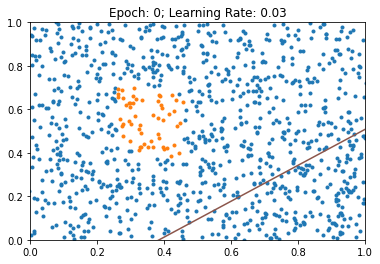

  Loss: 0.05194114148616791
Beta-N1: -0.9845959544181824
Beta-N2: 1.0663331747055054
Beta-N3: -0.47333967685699463
Beta-N4: -0.9804843068122864
Beta-OR: -1.051452398300171


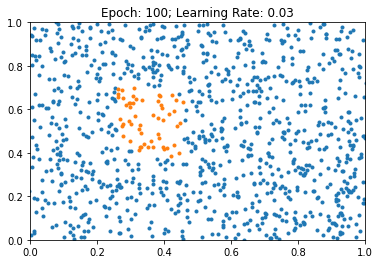

  Loss: 0.051669638603925705
Beta-N1: -0.9355790615081787
Beta-N2: 0.9174689054489136
Beta-N3: -0.47961562871932983
Beta-N4: -0.9228351712226868
Beta-OR: -1.0405787229537964


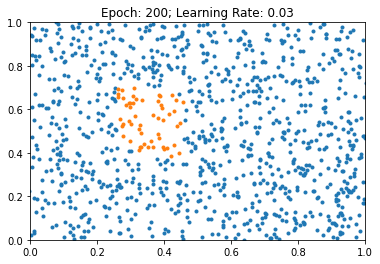

  Loss: 0.05154004320502281
Beta-N1: -0.9389525055885315
Beta-N2: 0.8778625130653381
Beta-N3: -0.5326477885246277
Beta-N4: -0.959811806678772
Beta-OR: -1.0669946670532227


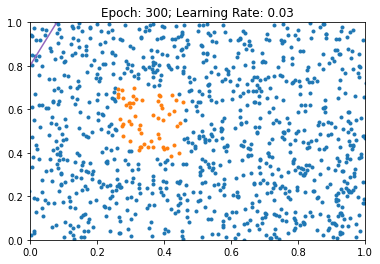

  Loss: 0.051498282700777054
Beta-N1: -0.940061092376709
Beta-N2: 0.8609175086021423
Beta-N3: -0.5588902235031128
Beta-N4: -0.9888659119606018
Beta-OR: -1.0957553386688232


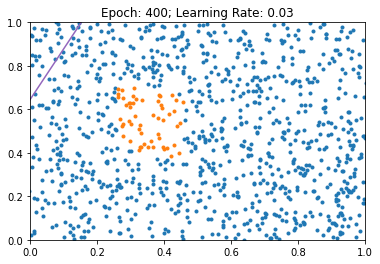

  Loss: 0.05147162824869156
Beta-N1: -0.9366095662117004
Beta-N2: 0.8655074834823608
Beta-N3: -0.5599663257598877
Beta-N4: -1.0058622360229492
Beta-OR: -1.1225614547729492


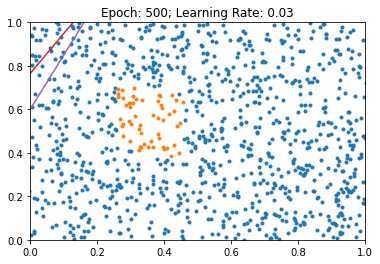

  Loss: 0.0514143705368042
Beta-N1: -0.9439209699630737
Beta-N2: 0.9677866697311401
Beta-N3: -0.5498533844947815
Beta-N4: -1.033846378326416
Beta-OR: -1.1514934301376343


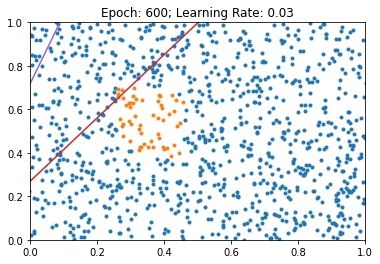

  Loss: 0.05087030678987503
Beta-N1: -0.9958160519599915
Beta-N2: 1.6400622129440308
Beta-N3: -0.5431293249130249
Beta-N4: -1.1183853149414062
Beta-OR: -1.1982371807098389


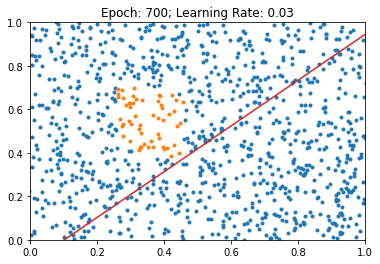

  Loss: 0.05011668801307678
Beta-N1: -0.9150741696357727
Beta-N2: 2.615135431289673
Beta-N3: -0.44459378719329834
Beta-N4: -1.0233830213546753
Beta-OR: -1.2268528938293457


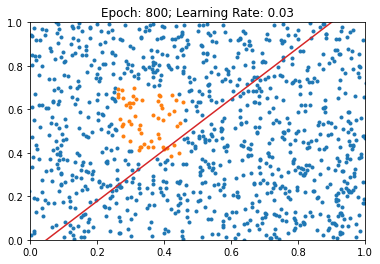

  Loss: 0.04974699765443802
Beta-N1: -0.839210569858551
Beta-N2: 3.235257387161255
Beta-N3: -0.37952229380607605
Beta-N4: -0.9154589176177979
Beta-OR: -1.285226821899414


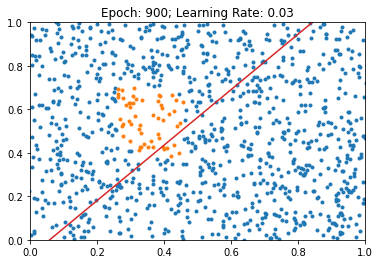

  Loss: 0.049500126391649246
Beta-N1: -0.7799543142318726
Beta-N2: 3.6714558601379395
Beta-N3: -0.3517190217971802
Beta-N4: -0.8161376118659973
Beta-OR: -1.3707973957061768


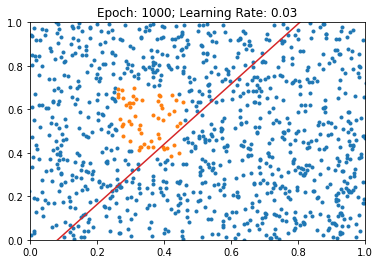

  Loss: 0.04928503558039665
Beta-N1: -0.734538197517395
Beta-N2: 4.007087230682373
Beta-N3: -0.342571884393692
Beta-N4: -0.7331400513648987
Beta-OR: -1.475426197052002


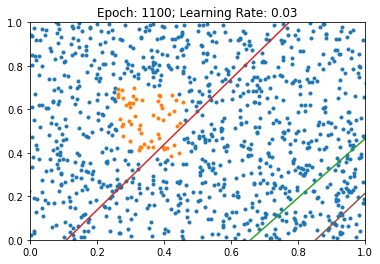

  Loss: 0.04905841499567032
Beta-N1: -0.7130983471870422
Beta-N2: 4.2768168449401855
Beta-N3: -0.34656962752342224
Beta-N4: -0.6859939694404602
Beta-OR: -1.5964908599853516


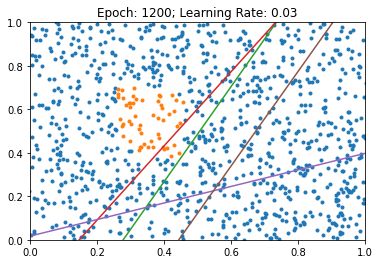

  Loss: 0.048672065138816833
Beta-N1: -0.7494781613349915
Beta-N2: 4.542181015014648
Beta-N3: -0.3580174148082733
Beta-N4: -0.7003536224365234
Beta-OR: -1.741530418395996


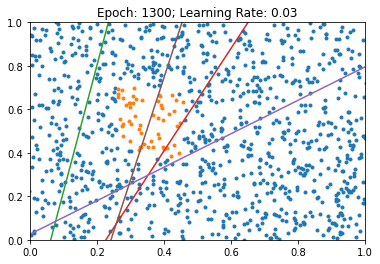

  Loss: 0.04770326241850853
Beta-N1: -1.146183729171753
Beta-N2: 4.884087562561035
Beta-N3: -0.38484880328178406
Beta-N4: -0.7105785608291626
Beta-OR: -1.939325213432312


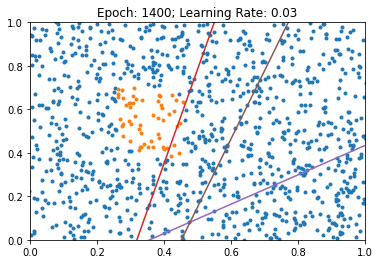

  Loss: 0.04262988641858101
Beta-N1: -3.449941635131836
Beta-N2: 5.322192192077637
Beta-N3: -0.34234559535980225
Beta-N4: -0.13833674788475037
Beta-OR: -2.209991455078125


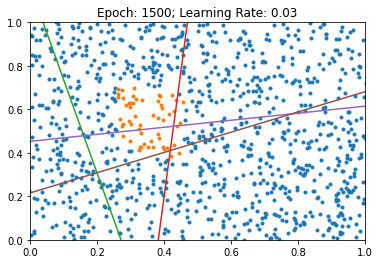

  Loss: 0.028442123904824257
Beta-N1: -4.752565860748291
Beta-N2: 5.760988235473633
Beta-N3: -2.4361937046051025
Beta-N4: -0.13318756222724915
Beta-OR: -2.7549586296081543


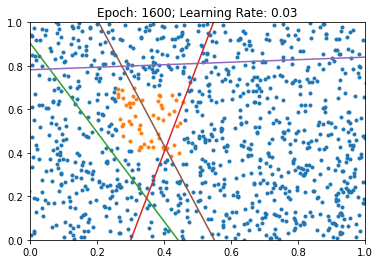

  Loss: 0.02011728659272194
Beta-N1: -5.606267929077148
Beta-N2: 6.136013031005859
Beta-N3: -3.572993516921997
Beta-N4: -1.1625343561172485
Beta-OR: -3.557565927505493


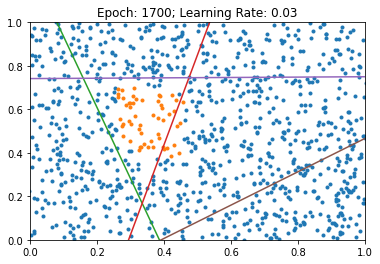

  Loss: 0.016459699720144272
Beta-N1: -6.206730842590332
Beta-N2: 6.303366661071777
Beta-N3: -4.035719871520996
Beta-N4: -2.089653968811035
Beta-OR: -4.149001121520996


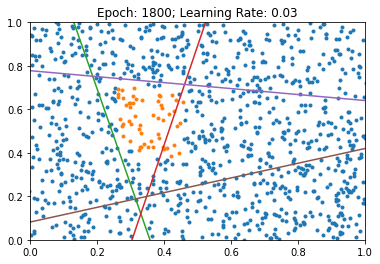

  Loss: 0.012687533162534237
Beta-N1: -6.637338638305664
Beta-N2: 6.520216464996338
Beta-N3: -4.34272575378418
Beta-N4: -4.009895324707031
Beta-OR: -4.610138893127441


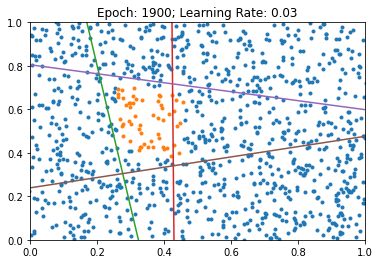

In [ ]:
learning_rate = 0.03
network = SimpleNetwork()
optimizer = optim.Adam(network.parameters(),learning_rate)
criterion = nn.MSELoss()

x = torch.linspace(-3,3)

beta_n1_arr = []
beta_n2_arr = []
beta_n3_arr = []
beta_n4_arr = []

beta_gerade_arr = []

beta_or_arr = []
loss_arr = []
running_loss =0

for epoch in range(2000):
    preds = network(trainX)
    #print(preds)
    loss = criterion(preds, trainY) # Calculate loss
    optimizer.zero_grad()
    loss.backward() # Calculate Gradient
    optimizer.step() # Update Weights

    beta_n1_arr.append(beta_n1)
    beta_n2_arr.append(beta_n2)
    beta_n3_arr.append(beta_n3)
    beta_n4_arr.append(beta_n4)

    beta_gerade_arr.append(beta_gerade)

    beta_or_arr.append(beta_or)
    loss_arr.append(loss.item())

    running_loss += loss.item()
    if epoch %100 == 0:


        y1 = -((network.n1.weight.squeeze()[0] * x + network.n1.bias[0]) / network.n1.weight.squeeze()[1])
        y2 = -((network.n2.weight.squeeze()[0] * x + network.n2.bias[0]) / network.n2.weight.squeeze()[1])
        y3 = -((network.n3.weight.squeeze()[0] * x + network.n3.bias[0]) / network.n3.weight.squeeze()[1])
        y4 = -((network.n4.weight.squeeze()[0] * x + network.n4.bias[0]) / network.n4.weight.squeeze()[1])

        #y5 = -((network.linear_layer_5.weight.squeeze()[0] * x + network.linear_layer_5.bias[0]) / network.linear_layer_5.weight.squeeze()[1])
        #y6 = -((network.linear_layer_6.weight.squeeze()[0] * x + network.linear_layer_6.bias[0]) / network.linear_layer_6.weight.squeeze()[1])

        #plt.figure(figsize=(12,6))
        plt.plot([i[0] for i in points if i[2] == 0], [i[1] for i in points if i[2] == 0], '.')
        plt.plot([i[0] for i in points if i[2] == 1], [i[1] for i in points if i[2] == 1], '.')

        plt.plot(x.numpy(), y1.detach().numpy(), '-')
        plt.plot(x.numpy(), y2.detach().numpy(), '-')
        plt.plot(x.numpy(), y3.detach().numpy(), '-')
        plt.plot(x.numpy(), y4.detach().numpy(), '-')
        #plt.plot(x.numpy(), y5.detach().numpy(), '-')
        #plt.plot(x.numpy(), y6.detach().numpy(), '-')
        #print("Beta:", betas)
        print(f'  Loss: {loss}')
        print("Beta-N1:", beta_n1)
        print("Beta-N2:", beta_n2)
        print("Beta-N3:", beta_n3)
        print("Beta-N4:", beta_n4)
        print("Beta-OR:", beta_or)
        plt.ylim(0,1)
        plt.xlim(0,1)
        plt.title(f'Epoch: {epoch}; Learning Rate: {learning_rate}')
        plt.show()

<function matplotlib.pyplot.show>

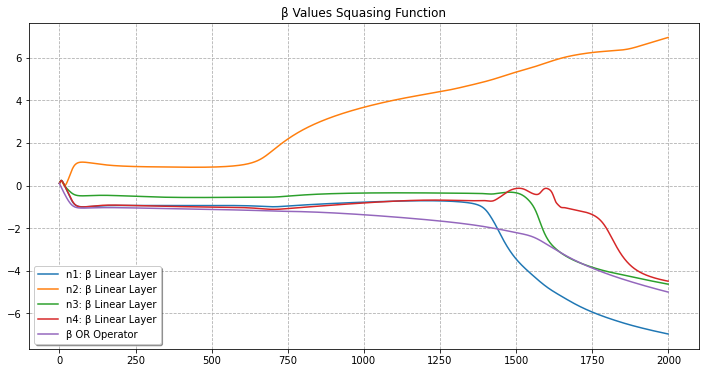

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(beta_n1_arr, label='n1: β Linear Layer')
plt.plot(beta_n2_arr, label='n2: β Linear Layer')
plt.plot(beta_n3_arr, label='n3: β Linear Layer')
plt.plot(beta_n4_arr, label='n4: β Linear Layer')
#plt.plot(beta_gerade_arr, label='ni: β Linear Layer')


plt.plot(beta_or_arr, label='β OR Operator')
plt.legend(loc=2)
plt.grid(True, axis='both', linestyle='--')
plt.title('β Values Squasing Function')
plt.legend(loc='lower left', ncol=1, fancybox=True, shadow=True)
plt.xlabel('Epochs [Train Time]')
# Set the y axis label of the current axis.
plt.ylabel('B Values')
plt.show

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Train Loss Squashing')
plt.plot(loss_arr, label='Loss', color='r')
plt.grid(True, axis='both', linestyle='--')
plt.xlabel('x - axis')
# Set the y axis label of the current axis.
plt.ylabel('y - axis')
plt.show

NameError: ignored

1*0 + 1*0 = 0
1*1 + 1*0 = 1
1*0 + 1*1 = 1
1*1 + 1*1 = 2
